# 1 

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add current directory to path to find 'core' and 'utils'
sys.path.append(os.getcwd())

from Core.models import Sequential
from Core.layers import RoughRBFLayer, RoughDenseLayer
from Core.losses import MSELoss
from Core.optimizers import SGD, CompetitiveLearning
from Utils.data_utils import DataHandler

# Visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported and environment set up.")

Libraries imported and environment set up.


# 2

In [2]:
def build_rough_rbf_network(input_dim, num_kernels, output_dim=1):
    """
    Creates a Rough RBF Network structure:
    Input -> RoughRBFLayer -> RoughDenseLayer -> Output
    """
    model = Sequential()
    # Layer 1: Rough RBF (Gaussian Kernels with Interval Parameters)
    model.add(RoughRBFLayer(input_dim=input_dim, num_kernels=num_kernels))
    # Layer 2: Rough Dense (Interval Weights)
    model.add(RoughDenseLayer(input_dim=num_kernels, output_dim=output_dim))
    return model

def plot_rough_predictions(model, X, y_true, title="Rough RBF Prediction", sample_range=None):
    """
    Runs prediction and plots True vs Predicted (Crisp) 
    along with the Lower and Upper bounds (Rough Interval).
    """
    # 1. Get Crisp Predictions
    y_pred_crisp = model.predict(X).flatten()
    y_true = y_true.flatten()
    
    # 2. Extract Lower and Upper bounds manually
    # Since model.predict returns the crisp value, we iterate to get internal states
    y_L_list = []
    y_U_list = []
    
    # Access the last layer (RoughDenseLayer) to get L/U bounds
    output_layer = model.layers[-1]
    
    for i in range(len(X)):
        model.forward(X[i]) # Run forward to update layer states
        y_L_list.append(output_layer.net_L.item())
        y_U_list.append(output_layer.net_U.item())
        
    y_L = np.array(y_L_list)
    y_U = np.array(y_U_list)
    
    # Optional: Zoom in on a specific range
    if sample_range:
        start, end = sample_range
        indices = range(start, end)
    else:
        indices = range(len(y_true))
        
    # 3. Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(indices, y_true[indices], color='black', label='Actual Data', linewidth=2)
    plt.plot(indices, y_pred_crisp[indices], color='red', linestyle='--', label='Crisp Prediction')
    
    # Fill the Rough Interval (Uncertainty)
    plt.fill_between(indices, y_L[indices], y_U[indices], color='red', alpha=0.2, label='Rough Interval [L, U]')
    
    plt.title(title)
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.show()

# 3

In [3]:
# Paths to datasets (Adjust if your folder structure is different)
LORENZ_PATH = '../HW2/Datasets/regression/Lorenz Dataset.xlsx'
TEMP_PATH = '../HW2/Datasets/regression/Temperature Dataset.xlsx'

# 1. Load Data
print("Loading Datasets...")
lorenz_raw = DataHandler.load_data(LORENZ_PATH)
temp_raw = DataHandler.load_data(TEMP_PATH)

# 2. Normalize Data (Crucial for RBF performance)
lorenz_norm, scaler_l = DataHandler.normalize_data(lorenz_raw)
temp_norm, scaler_t = DataHandler.normalize_data(temp_raw)

# 3. Create Sequences
# Question requires: 5 input steps, predict the 3rd future step
INPUT_STEPS = 5
PRED_HORIZON = 3

X_lorenz, y_lorenz = DataHandler.create_sequences(lorenz_norm, input_steps=INPUT_STEPS, prediction_horizon=PRED_HORIZON)
X_temp, y_temp = DataHandler.create_sequences(temp_norm, input_steps=INPUT_STEPS, prediction_horizon=PRED_HORIZON)

# 4. Train/Test Split (No shuffling for Time Series)
X_train_l, X_test_l, y_train_l, y_test_l = DataHandler.train_test_split(X_lorenz, y_lorenz, train_ratio=0.7, shuffle=False)
X_train_t, X_test_t, y_train_t, y_test_t = DataHandler.train_test_split(X_temp, y_temp, train_ratio=0.7, shuffle=False)

print(f"Lorenz Data: Train={X_train_l.shape}, Test={X_test_l.shape}")
print(f"Temperature Data: Train={X_train_t.shape}, Test={X_test_t.shape}")

Loading Datasets...
Lorenz Data: Train=(1395, 5), Test=(598, 5)
Temperature Data: Train=(230, 5), Test=(99, 5)


# 4

Training on Lorenz Dataset...
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598


Epoch 1/50: 100%|██████████| 1395/1395 [00:01<00:00, 783.99sample/s, train_loss=0.00016]


Epoch 1 finished. Train Loss: 0.004136 | Val Loss: 0.012751


Epoch 2/50: 100%|██████████| 1395/1395 [00:01<00:00, 764.69sample/s, train_loss=0.00016]


Epoch 2 finished. Train Loss: 0.002845 | Val Loss: 0.008923


Epoch 3/50: 100%|██████████| 1395/1395 [00:01<00:00, 776.66sample/s, train_loss=0.00018]


Epoch 3 finished. Train Loss: 0.002127 | Val Loss: 0.006776


Epoch 4/50: 100%|██████████| 1395/1395 [00:01<00:00, 756.23sample/s, train_loss=0.00019]


Epoch 4 finished. Train Loss: 0.001692 | Val Loss: 0.005443


Epoch 5/50: 100%|██████████| 1395/1395 [00:01<00:00, 807.81sample/s, train_loss=0.00019]


Epoch 5 finished. Train Loss: 0.001411 | Val Loss: 0.004546


Epoch 6/50: 100%|██████████| 1395/1395 [00:01<00:00, 802.51sample/s, train_loss=0.00018]


Epoch 6 finished. Train Loss: 0.001218 | Val Loss: 0.003896


Epoch 7/50: 100%|██████████| 1395/1395 [00:01<00:00, 803.62sample/s, train_loss=0.00017]


Epoch 7 finished. Train Loss: 0.001077 | Val Loss: 0.003390


Epoch 8/50: 100%|██████████| 1395/1395 [00:01<00:00, 797.66sample/s, train_loss=0.00016]


Epoch 8 finished. Train Loss: 0.000968 | Val Loss: 0.002976


Epoch 9/50: 100%|██████████| 1395/1395 [00:01<00:00, 808.06sample/s, train_loss=0.00014]


Epoch 9 finished. Train Loss: 0.000880 | Val Loss: 0.002624


Epoch 10/50: 100%|██████████| 1395/1395 [00:01<00:00, 810.85sample/s, train_loss=0.00012]


Epoch 10 finished. Train Loss: 0.000807 | Val Loss: 0.002318


Epoch 11/50: 100%|██████████| 1395/1395 [00:01<00:00, 781.00sample/s, train_loss=0.00011]


Epoch 11 finished. Train Loss: 0.000744 | Val Loss: 0.002050


Epoch 12/50: 100%|██████████| 1395/1395 [00:01<00:00, 783.19sample/s, train_loss=0.00009]


Epoch 12 finished. Train Loss: 0.000689 | Val Loss: 0.001814


Epoch 13/50: 100%|██████████| 1395/1395 [00:01<00:00, 772.25sample/s, train_loss=0.00007]


Epoch 13 finished. Train Loss: 0.000640 | Val Loss: 0.001605


Epoch 14/50: 100%|██████████| 1395/1395 [00:01<00:00, 700.94sample/s, train_loss=0.00006]


Epoch 14 finished. Train Loss: 0.000597 | Val Loss: 0.001420


Epoch 15/50: 100%|██████████| 1395/1395 [00:01<00:00, 725.35sample/s, train_loss=0.00004]


Epoch 15 finished. Train Loss: 0.000558 | Val Loss: 0.001258


Epoch 16/50: 100%|██████████| 1395/1395 [00:01<00:00, 784.80sample/s, train_loss=0.00003]


Epoch 16 finished. Train Loss: 0.000523 | Val Loss: 0.001116


Epoch 17/50: 100%|██████████| 1395/1395 [00:01<00:00, 788.61sample/s, train_loss=0.00002]


Epoch 17 finished. Train Loss: 0.000491 | Val Loss: 0.000993


Epoch 18/50: 100%|██████████| 1395/1395 [00:01<00:00, 771.19sample/s, train_loss=0.00002]


Epoch 18 finished. Train Loss: 0.000463 | Val Loss: 0.000887


Epoch 19/50: 100%|██████████| 1395/1395 [00:01<00:00, 787.22sample/s, train_loss=0.00001]


Epoch 19 finished. Train Loss: 0.000438 | Val Loss: 0.000797


Epoch 20/50: 100%|██████████| 1395/1395 [00:01<00:00, 762.80sample/s, train_loss=0.00001]


Epoch 20 finished. Train Loss: 0.000416 | Val Loss: 0.000720


Epoch 21/50: 100%|██████████| 1395/1395 [00:01<00:00, 881.10sample/s, train_loss=0.00000]


Epoch 21 finished. Train Loss: 0.000396 | Val Loss: 0.000656


Epoch 22/50: 100%|██████████| 1395/1395 [00:01<00:00, 878.42sample/s, train_loss=0.00000]


Epoch 22 finished. Train Loss: 0.000378 | Val Loss: 0.000602


Epoch 23/50: 100%|██████████| 1395/1395 [00:01<00:00, 1016.16sample/s, train_loss=0.00000]


Epoch 23 finished. Train Loss: 0.000361 | Val Loss: 0.000558


Epoch 24/50: 100%|██████████| 1395/1395 [00:01<00:00, 1032.30sample/s, train_loss=0.00000]


Epoch 24 finished. Train Loss: 0.000347 | Val Loss: 0.000523


Epoch 25/50: 100%|██████████| 1395/1395 [00:01<00:00, 1003.40sample/s, train_loss=0.00000]


Epoch 25 finished. Train Loss: 0.000334 | Val Loss: 0.000495


Epoch 26/50: 100%|██████████| 1395/1395 [00:01<00:00, 1035.78sample/s, train_loss=0.00000]


Epoch 26 finished. Train Loss: 0.000322 | Val Loss: 0.000473


Epoch 27/50: 100%|██████████| 1395/1395 [00:01<00:00, 1031.58sample/s, train_loss=0.00000]


Epoch 27 finished. Train Loss: 0.000312 | Val Loss: 0.000457


Epoch 28/50: 100%|██████████| 1395/1395 [00:01<00:00, 1043.12sample/s, train_loss=0.00001]


Epoch 28 finished. Train Loss: 0.000303 | Val Loss: 0.000445


Epoch 29/50: 100%|██████████| 1395/1395 [00:01<00:00, 981.99sample/s, train_loss=0.00001]


Epoch 29 finished. Train Loss: 0.000294 | Val Loss: 0.000438


Epoch 30/50: 100%|██████████| 1395/1395 [00:02<00:00, 513.64sample/s, train_loss=0.00001]


Epoch 30 finished. Train Loss: 0.000287 | Val Loss: 0.000434


Epoch 31/50: 100%|██████████| 1395/1395 [00:02<00:00, 690.00sample/s, train_loss=0.00002]


Epoch 31 finished. Train Loss: 0.000280 | Val Loss: 0.000432


Epoch 32/50: 100%|██████████| 1395/1395 [00:01<00:00, 887.01sample/s, train_loss=0.00002]


Epoch 32 finished. Train Loss: 0.000274 | Val Loss: 0.000433


Epoch 33/50: 100%|██████████| 1395/1395 [00:01<00:00, 824.18sample/s, train_loss=0.00002]


Epoch 33 finished. Train Loss: 0.000268 | Val Loss: 0.000436


Epoch 34/50: 100%|██████████| 1395/1395 [00:01<00:00, 906.01sample/s, train_loss=0.00003]


Epoch 34 finished. Train Loss: 0.000263 | Val Loss: 0.000440


Epoch 35/50: 100%|██████████| 1395/1395 [00:01<00:00, 901.39sample/s, train_loss=0.00003]


Epoch 35 finished. Train Loss: 0.000259 | Val Loss: 0.000446


Epoch 36/50: 100%|██████████| 1395/1395 [00:01<00:00, 944.52sample/s, train_loss=0.00003]


Epoch 36 finished. Train Loss: 0.000254 | Val Loss: 0.000452


Epoch 37/50: 100%|██████████| 1395/1395 [00:01<00:00, 963.43sample/s, train_loss=0.00004] 


Epoch 37 finished. Train Loss: 0.000251 | Val Loss: 0.000459


Epoch 38/50: 100%|██████████| 1395/1395 [00:01<00:00, 1039.37sample/s, train_loss=0.00004]


Epoch 38 finished. Train Loss: 0.000247 | Val Loss: 0.000467


Epoch 39/50: 100%|██████████| 1395/1395 [00:01<00:00, 1011.99sample/s, train_loss=0.00004]


Epoch 39 finished. Train Loss: 0.000244 | Val Loss: 0.000474


Epoch 40/50: 100%|██████████| 1395/1395 [00:01<00:00, 954.64sample/s, train_loss=0.00005] 


Epoch 40 finished. Train Loss: 0.000241 | Val Loss: 0.000482


Epoch 41/50: 100%|██████████| 1395/1395 [00:01<00:00, 917.57sample/s, train_loss=0.00005]


Epoch 41 finished. Train Loss: 0.000238 | Val Loss: 0.000490


Epoch 42/50: 100%|██████████| 1395/1395 [00:01<00:00, 909.88sample/s, train_loss=0.00005]


Epoch 42 finished. Train Loss: 0.000236 | Val Loss: 0.000498


Epoch 43/50: 100%|██████████| 1395/1395 [00:01<00:00, 905.38sample/s, train_loss=0.00005]


Epoch 43 finished. Train Loss: 0.000233 | Val Loss: 0.000505


Epoch 44/50: 100%|██████████| 1395/1395 [00:01<00:00, 930.49sample/s, train_loss=0.00006]


Epoch 44 finished. Train Loss: 0.000231 | Val Loss: 0.000512


Epoch 45/50: 100%|██████████| 1395/1395 [00:01<00:00, 892.23sample/s, train_loss=0.00006]


Epoch 45 finished. Train Loss: 0.000229 | Val Loss: 0.000519


Epoch 46/50: 100%|██████████| 1395/1395 [00:01<00:00, 797.78sample/s, train_loss=0.00006]


Epoch 46 finished. Train Loss: 0.000227 | Val Loss: 0.000526


Epoch 47/50: 100%|██████████| 1395/1395 [00:01<00:00, 977.57sample/s, train_loss=0.00006] 


Epoch 47 finished. Train Loss: 0.000225 | Val Loss: 0.000532


Epoch 48/50: 100%|██████████| 1395/1395 [00:01<00:00, 876.69sample/s, train_loss=0.00007]


Epoch 48 finished. Train Loss: 0.000223 | Val Loss: 0.000538


Epoch 49/50: 100%|██████████| 1395/1395 [00:01<00:00, 1029.22sample/s, train_loss=0.00007]


Epoch 49 finished. Train Loss: 0.000221 | Val Loss: 0.000543


Epoch 50/50: 100%|██████████| 1395/1395 [00:01<00:00, 1008.31sample/s, train_loss=0.00007]


Epoch 50 finished. Train Loss: 0.000220 | Val Loss: 0.000548
Training Complete. Time: 84.37s


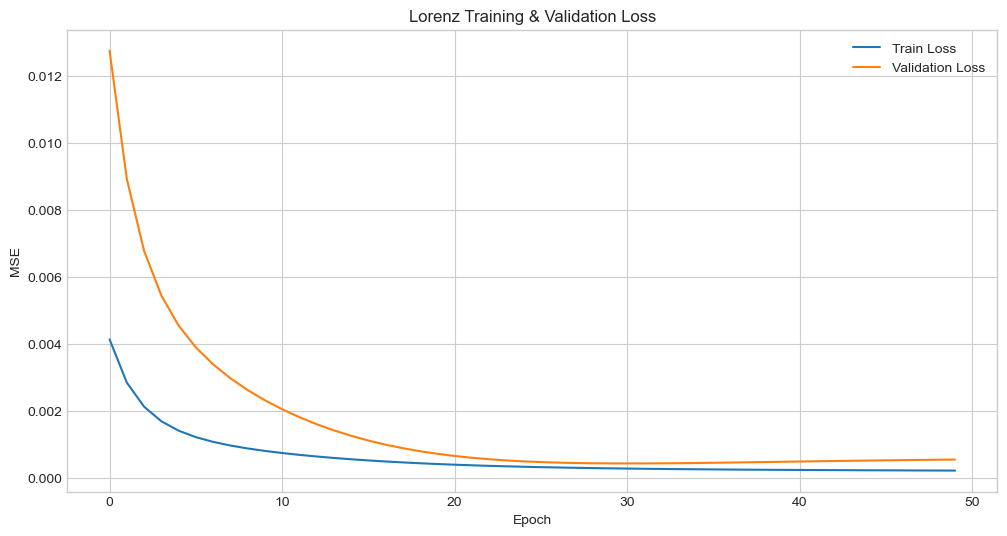

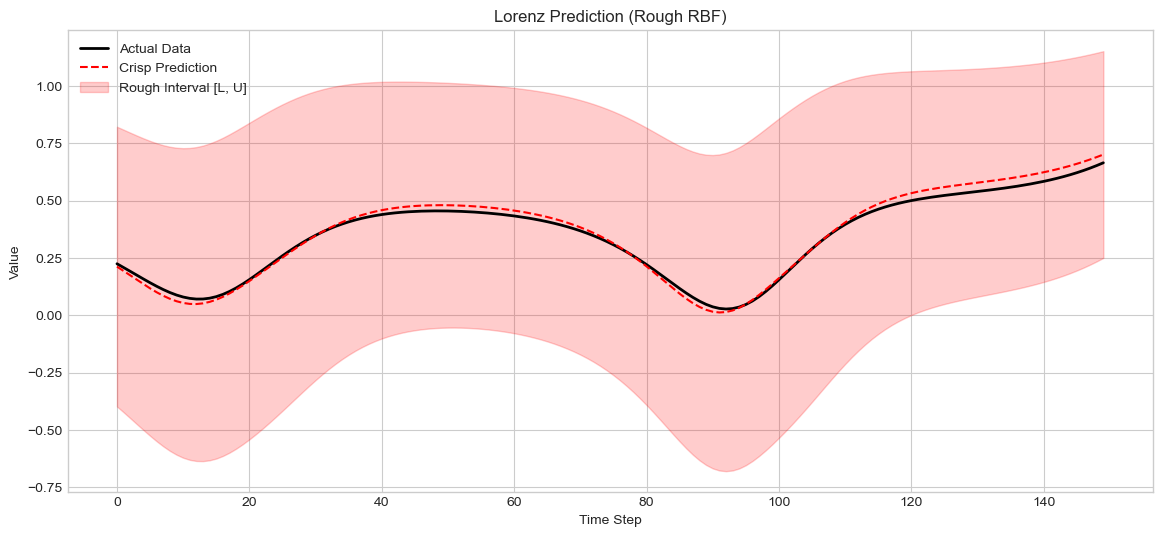

In [4]:
# --- Lorenz Training ---

# 1. Build Model
# Input dim = 5, using 20 Kernels for complex chaotic dynamics
model_lorenz = build_rough_rbf_network(input_dim=5, num_kernels=20)

# 2. Compile
# Learning rates: Base=0.05, Centers=0.01, Sigmas=0.01
optimizer = SGD(lr=0.05, lr_centers=0.01, lr_sigmas=0.01)
loss_fn = MSELoss()

model_lorenz.compile(loss=loss_fn, optimizer=optimizer)

# 3. Train
# Passing validation_data to monitor overfitting
print("Training on Lorenz Dataset...")
history_l = model_lorenz.fit(X_train_l, y_train_l, 
                             validation_data=(X_test_l, y_test_l), 
                             epochs=50, verbose=True)

# 4. Plot Loss
plt.figure()
plt.plot(history_l['loss'], label='Train Loss')
plt.plot(history_l['val_loss'], label='Validation Loss')
plt.title("Lorenz Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# 5. Visualize Predictions (Zoom in on first 100 test samples)
plot_rough_predictions(model_lorenz, X_test_l, y_test_l, 
                       title="Lorenz Prediction (Rough RBF)", sample_range=(0, 150))

# 5

Training on Temperature Dataset...
Starting Training | Mode: SGD | Epochs: 100 | Samples: 230
Validation enabled | Val Samples: 99


Epoch 1/100: 100%|██████████| 230/230 [00:00<00:00, 676.31sample/s, train_loss=0.01313]


Epoch 1 finished. Train Loss: 0.037924 | Val Loss: 0.091472


Epoch 2/100: 100%|██████████| 230/230 [00:00<00:00, 937.15sample/s, train_loss=0.01673]


Epoch 2 finished. Train Loss: 0.041708 | Val Loss: 0.090481


Epoch 3/100: 100%|██████████| 230/230 [00:00<00:00, 954.32sample/s, train_loss=0.01666]


Epoch 3 finished. Train Loss: 0.038729 | Val Loss: 0.081909


Epoch 4/100: 100%|██████████| 230/230 [00:00<00:00, 920.55sample/s, train_loss=0.01650]


Epoch 4 finished. Train Loss: 0.034851 | Val Loss: 0.074183


Epoch 5/100: 100%|██████████| 230/230 [00:00<00:00, 874.22sample/s, train_loss=0.01634]


Epoch 5 finished. Train Loss: 0.031414 | Val Loss: 0.067307


Epoch 6/100: 100%|██████████| 230/230 [00:00<00:00, 562.98sample/s, train_loss=0.01620]


Epoch 6 finished. Train Loss: 0.028385 | Val Loss: 0.061178


Epoch 7/100: 100%|██████████| 230/230 [00:00<00:00, 559.93sample/s, train_loss=0.01607]


Epoch 7 finished. Train Loss: 0.025712 | Val Loss: 0.055700


Epoch 8/100: 100%|██████████| 230/230 [00:00<00:00, 589.93sample/s, train_loss=0.01594]


Epoch 8 finished. Train Loss: 0.023353 | Val Loss: 0.050802


Epoch 9/100: 100%|██████████| 230/230 [00:00<00:00, 815.39sample/s, train_loss=0.01582]


Epoch 9 finished. Train Loss: 0.021272 | Val Loss: 0.046415


Epoch 10/100: 100%|██████████| 230/230 [00:00<00:00, 936.11sample/s, train_loss=0.01571]


Epoch 10 finished. Train Loss: 0.019434 | Val Loss: 0.042481


Epoch 11/100: 100%|██████████| 230/230 [00:00<00:00, 920.19sample/s, train_loss=0.01560]


Epoch 11 finished. Train Loss: 0.017811 | Val Loss: 0.038948


Epoch 12/100: 100%|██████████| 230/230 [00:00<00:00, 740.06sample/s, train_loss=0.01549]


Epoch 12 finished. Train Loss: 0.016377 | Val Loss: 0.035775


Epoch 13/100: 100%|██████████| 230/230 [00:00<00:00, 898.58sample/s, train_loss=0.01539]


Epoch 13 finished. Train Loss: 0.015113 | Val Loss: 0.032924


Epoch 14/100: 100%|██████████| 230/230 [00:00<00:00, 919.65sample/s, train_loss=0.01530]


Epoch 14 finished. Train Loss: 0.013997 | Val Loss: 0.030360


Epoch 15/100: 100%|██████████| 230/230 [00:00<00:00, 747.10sample/s, train_loss=0.01520]


Epoch 15 finished. Train Loss: 0.013014 | Val Loss: 0.028055


Epoch 16/100: 100%|██████████| 230/230 [00:00<00:00, 719.68sample/s, train_loss=0.01512]


Epoch 16 finished. Train Loss: 0.012148 | Val Loss: 0.025981


Epoch 17/100: 100%|██████████| 230/230 [00:00<00:00, 848.55sample/s, train_loss=0.01503]


Epoch 17 finished. Train Loss: 0.011385 | Val Loss: 0.024115


Epoch 18/100: 100%|██████████| 230/230 [00:00<00:00, 793.38sample/s, train_loss=0.01495]


Epoch 18 finished. Train Loss: 0.010714 | Val Loss: 0.022436


Epoch 19/100: 100%|██████████| 230/230 [00:00<00:00, 889.70sample/s, train_loss=0.01487]


Epoch 19 finished. Train Loss: 0.010125 | Val Loss: 0.020924


Epoch 20/100: 100%|██████████| 230/230 [00:00<00:00, 934.79sample/s, train_loss=0.01479]


Epoch 20 finished. Train Loss: 0.009607 | Val Loss: 0.019563


Epoch 21/100: 100%|██████████| 230/230 [00:00<00:00, 773.98sample/s, train_loss=0.01472]


Epoch 21 finished. Train Loss: 0.009152 | Val Loss: 0.018336


Epoch 22/100: 100%|██████████| 230/230 [00:00<00:00, 970.31sample/s, train_loss=0.01465]


Epoch 22 finished. Train Loss: 0.008753 | Val Loss: 0.017232


Epoch 23/100: 100%|██████████| 230/230 [00:00<00:00, 978.17sample/s, train_loss=0.01458]


Epoch 23 finished. Train Loss: 0.008403 | Val Loss: 0.016236


Epoch 24/100: 100%|██████████| 230/230 [00:00<00:00, 957.91sample/s, train_loss=0.01452]


Epoch 24 finished. Train Loss: 0.008097 | Val Loss: 0.015339


Epoch 25/100: 100%|██████████| 230/230 [00:00<00:00, 875.26sample/s, train_loss=0.01446]


Epoch 25 finished. Train Loss: 0.007828 | Val Loss: 0.014529


Epoch 26/100: 100%|██████████| 230/230 [00:00<00:00, 818.33sample/s, train_loss=0.01440]


Epoch 26 finished. Train Loss: 0.007593 | Val Loss: 0.013798


Epoch 27/100: 100%|██████████| 230/230 [00:00<00:00, 825.80sample/s, train_loss=0.01434]


Epoch 27 finished. Train Loss: 0.007388 | Val Loss: 0.013138


Epoch 28/100: 100%|██████████| 230/230 [00:00<00:00, 632.52sample/s, train_loss=0.01429]


Epoch 28 finished. Train Loss: 0.007207 | Val Loss: 0.012541


Epoch 29/100: 100%|██████████| 230/230 [00:00<00:00, 855.02sample/s, train_loss=0.01423]


Epoch 29 finished. Train Loss: 0.007049 | Val Loss: 0.012001


Epoch 30/100: 100%|██████████| 230/230 [00:00<00:00, 860.73sample/s, train_loss=0.01418]


Epoch 30 finished. Train Loss: 0.006911 | Val Loss: 0.011511


Epoch 31/100: 100%|██████████| 230/230 [00:00<00:00, 932.72sample/s, train_loss=0.01414]


Epoch 31 finished. Train Loss: 0.006790 | Val Loss: 0.011069


Epoch 32/100: 100%|██████████| 230/230 [00:00<00:00, 904.38sample/s, train_loss=0.01409]


Epoch 32 finished. Train Loss: 0.006684 | Val Loss: 0.010667


Epoch 33/100: 100%|██████████| 230/230 [00:00<00:00, 716.14sample/s, train_loss=0.01405]


Epoch 33 finished. Train Loss: 0.006591 | Val Loss: 0.010302


Epoch 34/100: 100%|██████████| 230/230 [00:00<00:00, 804.19sample/s, train_loss=0.01401]


Epoch 34 finished. Train Loss: 0.006509 | Val Loss: 0.009971


Epoch 35/100: 100%|██████████| 230/230 [00:00<00:00, 845.69sample/s, train_loss=0.01397]


Epoch 35 finished. Train Loss: 0.006437 | Val Loss: 0.009669


Epoch 36/100: 100%|██████████| 230/230 [00:00<00:00, 930.49sample/s, train_loss=0.01393]


Epoch 36 finished. Train Loss: 0.006373 | Val Loss: 0.009394


Epoch 37/100: 100%|██████████| 230/230 [00:00<00:00, 708.26sample/s, train_loss=0.01389]


Epoch 37 finished. Train Loss: 0.006317 | Val Loss: 0.009144


Epoch 38/100: 100%|██████████| 230/230 [00:00<00:00, 858.84sample/s, train_loss=0.01386]


Epoch 38 finished. Train Loss: 0.006267 | Val Loss: 0.008915


Epoch 39/100: 100%|██████████| 230/230 [00:00<00:00, 919.97sample/s, train_loss=0.01383]


Epoch 39 finished. Train Loss: 0.006223 | Val Loss: 0.008706


Epoch 40/100: 100%|██████████| 230/230 [00:00<00:00, 828.38sample/s, train_loss=0.01379]


Epoch 40 finished. Train Loss: 0.006184 | Val Loss: 0.008514


Epoch 41/100: 100%|██████████| 230/230 [00:00<00:00, 932.77sample/s, train_loss=0.01376]


Epoch 41 finished. Train Loss: 0.006149 | Val Loss: 0.008339


Epoch 42/100: 100%|██████████| 230/230 [00:00<00:00, 673.05sample/s, train_loss=0.01373]


Epoch 42 finished. Train Loss: 0.006118 | Val Loss: 0.008178


Epoch 43/100: 100%|██████████| 230/230 [00:00<00:00, 908.06sample/s, train_loss=0.01371]


Epoch 43 finished. Train Loss: 0.006090 | Val Loss: 0.008030


Epoch 44/100: 100%|██████████| 230/230 [00:00<00:00, 800.76sample/s, train_loss=0.01368]


Epoch 44 finished. Train Loss: 0.006065 | Val Loss: 0.007894


Epoch 45/100: 100%|██████████| 230/230 [00:00<00:00, 886.24sample/s, train_loss=0.01365]


Epoch 45 finished. Train Loss: 0.006042 | Val Loss: 0.007768


Epoch 46/100: 100%|██████████| 230/230 [00:00<00:00, 747.59sample/s, train_loss=0.01363]


Epoch 46 finished. Train Loss: 0.006021 | Val Loss: 0.007653


Epoch 47/100: 100%|██████████| 230/230 [00:00<00:00, 825.43sample/s, train_loss=0.01361]


Epoch 47 finished. Train Loss: 0.006002 | Val Loss: 0.007546


Epoch 48/100: 100%|██████████| 230/230 [00:00<00:00, 816.95sample/s, train_loss=0.01358]


Epoch 48 finished. Train Loss: 0.005984 | Val Loss: 0.007448


Epoch 49/100: 100%|██████████| 230/230 [00:00<00:00, 809.87sample/s, train_loss=0.01356]


Epoch 49 finished. Train Loss: 0.005968 | Val Loss: 0.007357


Epoch 50/100: 100%|██████████| 230/230 [00:00<00:00, 617.75sample/s, train_loss=0.01354]


Epoch 50 finished. Train Loss: 0.005953 | Val Loss: 0.007273


Epoch 51/100: 100%|██████████| 230/230 [00:00<00:00, 841.45sample/s, train_loss=0.01352]


Epoch 51 finished. Train Loss: 0.005939 | Val Loss: 0.007194


Epoch 52/100: 100%|██████████| 230/230 [00:00<00:00, 858.16sample/s, train_loss=0.01350]


Epoch 52 finished. Train Loss: 0.005926 | Val Loss: 0.007121


Epoch 53/100: 100%|██████████| 230/230 [00:00<00:00, 845.15sample/s, train_loss=0.01348]


Epoch 53 finished. Train Loss: 0.005913 | Val Loss: 0.007054


Epoch 54/100: 100%|██████████| 230/230 [00:00<00:00, 886.76sample/s, train_loss=0.01346]


Epoch 54 finished. Train Loss: 0.005901 | Val Loss: 0.006991


Epoch 55/100: 100%|██████████| 230/230 [00:00<00:00, 871.52sample/s, train_loss=0.01344]


Epoch 55 finished. Train Loss: 0.005890 | Val Loss: 0.006932


Epoch 56/100: 100%|██████████| 230/230 [00:00<00:00, 662.83sample/s, train_loss=0.01343]


Epoch 56 finished. Train Loss: 0.005879 | Val Loss: 0.006877


Epoch 57/100: 100%|██████████| 230/230 [00:00<00:00, 920.00sample/s, train_loss=0.01341]


Epoch 57 finished. Train Loss: 0.005869 | Val Loss: 0.006825


Epoch 58/100: 100%|██████████| 230/230 [00:00<00:00, 930.13sample/s, train_loss=0.01339]


Epoch 58 finished. Train Loss: 0.005859 | Val Loss: 0.006777


Epoch 59/100: 100%|██████████| 230/230 [00:00<00:00, 727.84sample/s, train_loss=0.01338]


Epoch 59 finished. Train Loss: 0.005849 | Val Loss: 0.006731


Epoch 60/100: 100%|██████████| 230/230 [00:00<00:00, 704.08sample/s, train_loss=0.01336]


Epoch 60 finished. Train Loss: 0.005840 | Val Loss: 0.006689


Epoch 61/100: 100%|██████████| 230/230 [00:00<00:00, 904.49sample/s, train_loss=0.01335]


Epoch 61 finished. Train Loss: 0.005831 | Val Loss: 0.006649


Epoch 62/100: 100%|██████████| 230/230 [00:00<00:00, 925.00sample/s, train_loss=0.01333]


Epoch 62 finished. Train Loss: 0.005822 | Val Loss: 0.006611


Epoch 63/100: 100%|██████████| 230/230 [00:00<00:00, 815.62sample/s, train_loss=0.01332]


Epoch 63 finished. Train Loss: 0.005813 | Val Loss: 0.006575


Epoch 64/100: 100%|██████████| 230/230 [00:00<00:00, 792.45sample/s, train_loss=0.01330]


Epoch 64 finished. Train Loss: 0.005804 | Val Loss: 0.006542


Epoch 65/100: 100%|██████████| 230/230 [00:00<00:00, 883.45sample/s, train_loss=0.01329]


Epoch 65 finished. Train Loss: 0.005796 | Val Loss: 0.006510


Epoch 66/100: 100%|██████████| 230/230 [00:00<00:00, 942.64sample/s, train_loss=0.01327]


Epoch 66 finished. Train Loss: 0.005788 | Val Loss: 0.006479


Epoch 67/100: 100%|██████████| 230/230 [00:00<00:00, 804.21sample/s, train_loss=0.01326]


Epoch 67 finished. Train Loss: 0.005780 | Val Loss: 0.006451


Epoch 68/100: 100%|██████████| 230/230 [00:00<00:00, 801.84sample/s, train_loss=0.01325]


Epoch 68 finished. Train Loss: 0.005772 | Val Loss: 0.006423


Epoch 69/100: 100%|██████████| 230/230 [00:00<00:00, 624.85sample/s, train_loss=0.01324]


Epoch 69 finished. Train Loss: 0.005764 | Val Loss: 0.006397


Epoch 70/100: 100%|██████████| 230/230 [00:00<00:00, 801.84sample/s, train_loss=0.01322]


Epoch 70 finished. Train Loss: 0.005756 | Val Loss: 0.006373


Epoch 71/100: 100%|██████████| 230/230 [00:00<00:00, 809.02sample/s, train_loss=0.01321]


Epoch 71 finished. Train Loss: 0.005749 | Val Loss: 0.006349


Epoch 72/100: 100%|██████████| 230/230 [00:00<00:00, 797.52sample/s, train_loss=0.01320]


Epoch 72 finished. Train Loss: 0.005741 | Val Loss: 0.006327


Epoch 73/100: 100%|██████████| 230/230 [00:00<00:00, 877.07sample/s, train_loss=0.01319]


Epoch 73 finished. Train Loss: 0.005734 | Val Loss: 0.006305


Epoch 74/100: 100%|██████████| 230/230 [00:00<00:00, 716.51sample/s, train_loss=0.01318]


Epoch 74 finished. Train Loss: 0.005726 | Val Loss: 0.006285


Epoch 75/100: 100%|██████████| 230/230 [00:00<00:00, 933.89sample/s, train_loss=0.01316]


Epoch 75 finished. Train Loss: 0.005719 | Val Loss: 0.006265


Epoch 76/100: 100%|██████████| 230/230 [00:00<00:00, 778.24sample/s, train_loss=0.01315]


Epoch 76 finished. Train Loss: 0.005712 | Val Loss: 0.006246


Epoch 77/100: 100%|██████████| 230/230 [00:00<00:00, 835.59sample/s, train_loss=0.01314]


Epoch 77 finished. Train Loss: 0.005705 | Val Loss: 0.006228


Epoch 78/100: 100%|██████████| 230/230 [00:00<00:00, 897.08sample/s, train_loss=0.01313]


Epoch 78 finished. Train Loss: 0.005698 | Val Loss: 0.006210


Epoch 79/100: 100%|██████████| 230/230 [00:00<00:00, 626.77sample/s, train_loss=0.01312]


Epoch 79 finished. Train Loss: 0.005691 | Val Loss: 0.006194


Epoch 80/100: 100%|██████████| 230/230 [00:00<00:00, 847.72sample/s, train_loss=0.01311]


Epoch 80 finished. Train Loss: 0.005684 | Val Loss: 0.006177


Epoch 81/100: 100%|██████████| 230/230 [00:00<00:00, 916.19sample/s, train_loss=0.01310]


Epoch 81 finished. Train Loss: 0.005677 | Val Loss: 0.006161


Epoch 82/100: 100%|██████████| 230/230 [00:00<00:00, 924.90sample/s, train_loss=0.01309]


Epoch 82 finished. Train Loss: 0.005670 | Val Loss: 0.006146


Epoch 83/100: 100%|██████████| 230/230 [00:00<00:00, 711.35sample/s, train_loss=0.01308]


Epoch 83 finished. Train Loss: 0.005663 | Val Loss: 0.006131


Epoch 84/100: 100%|██████████| 230/230 [00:00<00:00, 919.08sample/s, train_loss=0.01307]


Epoch 84 finished. Train Loss: 0.005656 | Val Loss: 0.006117


Epoch 85/100: 100%|██████████| 230/230 [00:00<00:00, 815.16sample/s, train_loss=0.01306]


Epoch 85 finished. Train Loss: 0.005650 | Val Loss: 0.006103


Epoch 86/100: 100%|██████████| 230/230 [00:00<00:00, 780.36sample/s, train_loss=0.01305]


Epoch 86 finished. Train Loss: 0.005643 | Val Loss: 0.006090


Epoch 87/100: 100%|██████████| 230/230 [00:00<00:00, 812.36sample/s, train_loss=0.01304]


Epoch 87 finished. Train Loss: 0.005637 | Val Loss: 0.006077


Epoch 88/100: 100%|██████████| 230/230 [00:00<00:00, 635.33sample/s, train_loss=0.01303]


Epoch 88 finished. Train Loss: 0.005630 | Val Loss: 0.006064


Epoch 89/100: 100%|██████████| 230/230 [00:00<00:00, 887.31sample/s, train_loss=0.01302]


Epoch 89 finished. Train Loss: 0.005624 | Val Loss: 0.006051


Epoch 90/100: 100%|██████████| 230/230 [00:00<00:00, 882.83sample/s, train_loss=0.01301]


Epoch 90 finished. Train Loss: 0.005617 | Val Loss: 0.006039


Epoch 91/100: 100%|██████████| 230/230 [00:00<00:00, 817.31sample/s, train_loss=0.01300]


Epoch 91 finished. Train Loss: 0.005611 | Val Loss: 0.006027


Epoch 92/100: 100%|██████████| 230/230 [00:00<00:00, 756.81sample/s, train_loss=0.01299]


Epoch 92 finished. Train Loss: 0.005605 | Val Loss: 0.006015


Epoch 93/100: 100%|██████████| 230/230 [00:00<00:00, 694.01sample/s, train_loss=0.01298]


Epoch 93 finished. Train Loss: 0.005599 | Val Loss: 0.006004


Epoch 94/100: 100%|██████████| 230/230 [00:00<00:00, 870.15sample/s, train_loss=0.01297]


Epoch 94 finished. Train Loss: 0.005592 | Val Loss: 0.005993


Epoch 95/100: 100%|██████████| 230/230 [00:00<00:00, 787.64sample/s, train_loss=0.01296]


Epoch 95 finished. Train Loss: 0.005586 | Val Loss: 0.005982


Epoch 96/100: 100%|██████████| 230/230 [00:00<00:00, 799.65sample/s, train_loss=0.01295]


Epoch 96 finished. Train Loss: 0.005580 | Val Loss: 0.005971


Epoch 97/100: 100%|██████████| 230/230 [00:00<00:00, 847.96sample/s, train_loss=0.01294]


Epoch 97 finished. Train Loss: 0.005574 | Val Loss: 0.005960


Epoch 98/100: 100%|██████████| 230/230 [00:00<00:00, 818.60sample/s, train_loss=0.01294]


Epoch 98 finished. Train Loss: 0.005568 | Val Loss: 0.005950


Epoch 99/100: 100%|██████████| 230/230 [00:00<00:00, 840.25sample/s, train_loss=0.01293]


Epoch 99 finished. Train Loss: 0.005562 | Val Loss: 0.005940


Epoch 100/100: 100%|██████████| 230/230 [00:00<00:00, 688.23sample/s, train_loss=0.01292]


Epoch 100 finished. Train Loss: 0.005556 | Val Loss: 0.005929
Training Complete. Time: 29.51s


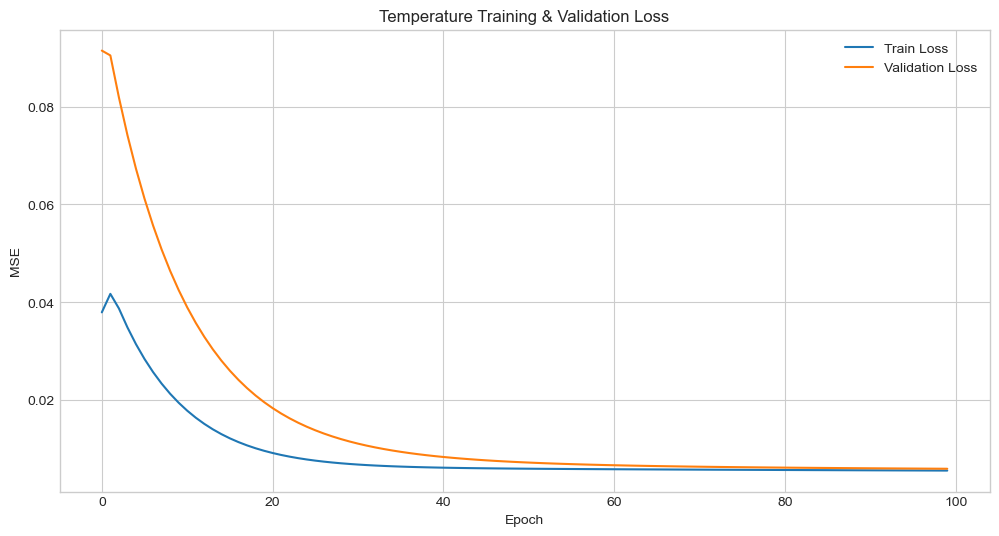

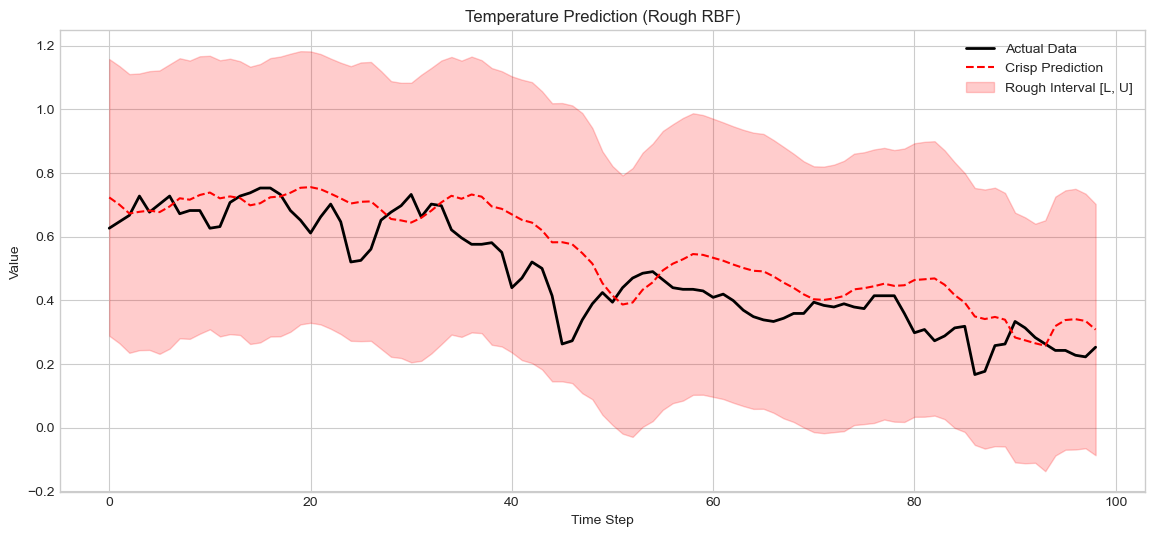

In [32]:
# --- Temperature Training ---

# 1. Build Model
# Temperature data is simpler, 10 kernels should suffice
model_temp = build_rough_rbf_network(input_dim=5, num_kernels=10)

# 2. Compile
# Slightly lower learning rate for stability on smaller dataset
optimizer = SGD(lr=0.01, lr_centers=0.005, lr_sigmas=0.005)
loss_fn = MSELoss()

model_temp.compile(loss=loss_fn, optimizer=optimizer)

# 3. Train
print("Training on Temperature Dataset...")
history_t = model_temp.fit(X_train_t, y_train_t, 
                           validation_data=(X_test_t, y_test_t),
                           epochs=100, verbose=True)

# 4. Plot Loss
plt.figure()
plt.plot(history_t['loss'], label='Train Loss')
plt.plot(history_t['val_loss'], label='Validation Loss')
plt.title("Temperature Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# 5. Visualize Predictions
plot_rough_predictions(model_temp, X_test_t, y_test_t, 
                       title="Temperature Prediction (Rough RBF)")

# 6

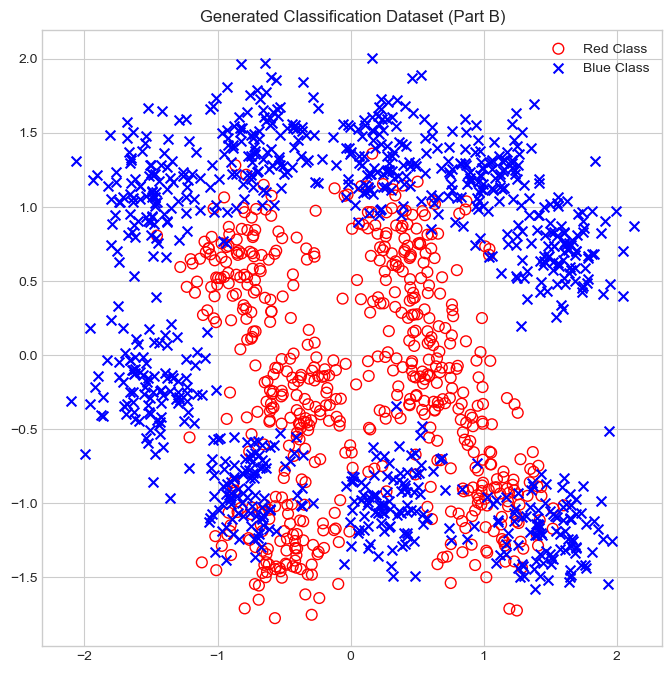

In [13]:
# 1. Generate Data
X_cls, y_cls = DataHandler.generate_classification_dataset()

# 2. Visualize Raw Data
plt.figure(figsize=(8, 8))
# Plot Red Class (Label 0)
plt.scatter(X_cls[y_cls.flatten()==0, 0], X_cls[y_cls.flatten()==0, 1], 
            facecolors='none', edgecolors='r', s=60, label='Red Class')
# Plot Blue Class (Label 1)
plt.scatter(X_cls[y_cls.flatten()==1, 0], X_cls[y_cls.flatten()==1, 1], 
            marker='x', c='b', s=50, label='Blue Class')

plt.title("Generated Classification Dataset (Part B)")
plt.legend()
plt.grid(True)
plt.show()

# 7

Running Unsupervised Competitive Learning...
Starting Competitive Learning for 30 epochs...
Epoch 10/30, Total Shift: 37.6247
Epoch 20/30, Total Shift: 34.1226
Epoch 30/30, Total Shift: 30.7084


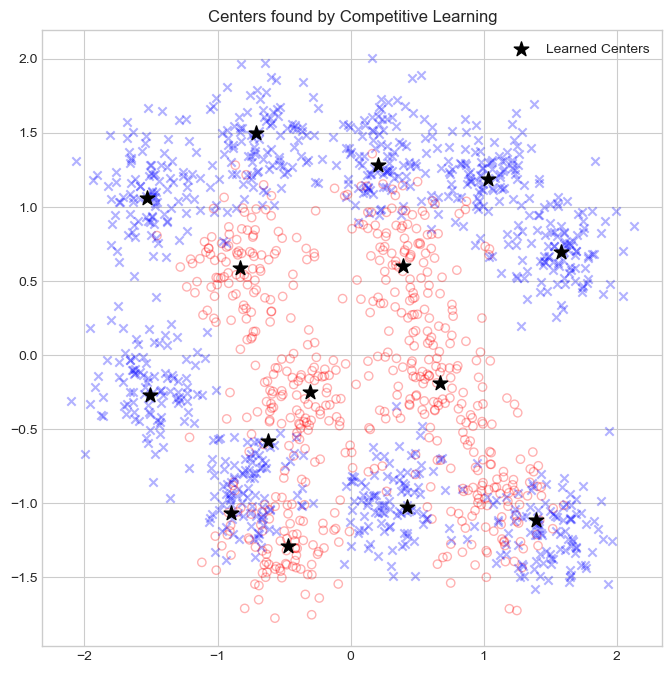

In [14]:
# We estimate number of centers based on the generation logic (6 red + 9 blue = 15)
NUM_CENTERS = 15
INPUT_DIM = 2

# 1. Initialize Competitive Learning
comp_learning = CompetitiveLearning(num_centers=NUM_CENTERS, input_dim=INPUT_DIM, learning_rate=0.1)

# 2. Fit to find centers (Unsupervised)
print("Running Unsupervised Competitive Learning...")
found_centers = comp_learning.fit(X_cls, epochs=30)

# 3. Visualize Centers
plt.figure(figsize=(8, 8))
plt.scatter(X_cls[y_cls.flatten()==0, 0], X_cls[y_cls.flatten()==0, 1], edgecolors='r', facecolors='none', alpha=0.3)
plt.scatter(X_cls[y_cls.flatten()==1, 0], X_cls[y_cls.flatten()==1, 1], marker='x', c='b', alpha=0.3)
plt.scatter(found_centers[:, 0], found_centers[:, 1], c='k', s=120, marker='*', label='Learned Centers')
plt.title("Centers found by Competitive Learning")
plt.legend()
plt.show()

# 8

Training Classification Network (Output Weights Only)...
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1200
Validation enabled | Val Samples: 300


Epoch 1/50: 100%|██████████| 1200/1200 [00:01<00:00, 1010.52sample/s, train_loss=0.40101]


Epoch 1 finished. Train Loss: 0.207400 | Val Loss: 0.128307


Epoch 2/50: 100%|██████████| 1200/1200 [00:01<00:00, 938.68sample/s, train_loss=0.30481] 


Epoch 2 finished. Train Loss: 0.120952 | Val Loss: 0.109609


Epoch 3/50: 100%|██████████| 1200/1200 [00:01<00:00, 1036.62sample/s, train_loss=0.24870]


Epoch 3 finished. Train Loss: 0.106419 | Val Loss: 0.101022


Epoch 4/50: 100%|██████████| 1200/1200 [00:01<00:00, 1076.77sample/s, train_loss=0.21907]


Epoch 4 finished. Train Loss: 0.098781 | Val Loss: 0.095853


Epoch 5/50: 100%|██████████| 1200/1200 [00:01<00:00, 1036.54sample/s, train_loss=0.20242]


Epoch 5 finished. Train Loss: 0.093701 | Val Loss: 0.092148


Epoch 6/50: 100%|██████████| 1200/1200 [00:01<00:00, 954.00sample/s, train_loss=0.19243]


Epoch 6 finished. Train Loss: 0.089851 | Val Loss: 0.089258


Epoch 7/50: 100%|██████████| 1200/1200 [00:01<00:00, 914.17sample/s, train_loss=0.18608]


Epoch 7 finished. Train Loss: 0.086753 | Val Loss: 0.086927


Epoch 8/50: 100%|██████████| 1200/1200 [00:01<00:00, 858.80sample/s, train_loss=0.18181]


Epoch 8 finished. Train Loss: 0.084194 | Val Loss: 0.085019


Epoch 9/50: 100%|██████████| 1200/1200 [00:01<00:00, 950.92sample/s, train_loss=0.17884]


Epoch 9 finished. Train Loss: 0.082054 | Val Loss: 0.083448


Epoch 10/50: 100%|██████████| 1200/1200 [00:01<00:00, 961.79sample/s, train_loss=0.17670]


Epoch 10 finished. Train Loss: 0.080252 | Val Loss: 0.082152


Epoch 11/50: 100%|██████████| 1200/1200 [00:01<00:00, 976.84sample/s, train_loss=0.17516]


Epoch 11 finished. Train Loss: 0.078727 | Val Loss: 0.081080


Epoch 12/50: 100%|██████████| 1200/1200 [00:01<00:00, 1079.47sample/s, train_loss=0.17404]


Epoch 12 finished. Train Loss: 0.077431 | Val Loss: 0.080192


Epoch 13/50: 100%|██████████| 1200/1200 [00:01<00:00, 919.67sample/s, train_loss=0.17327]


Epoch 13 finished. Train Loss: 0.076326 | Val Loss: 0.079455


Epoch 14/50: 100%|██████████| 1200/1200 [00:01<00:00, 1043.03sample/s, train_loss=0.17275]


Epoch 14 finished. Train Loss: 0.075380 | Val Loss: 0.078844


Epoch 15/50: 100%|██████████| 1200/1200 [00:01<00:00, 1047.21sample/s, train_loss=0.17246]


Epoch 15 finished. Train Loss: 0.074567 | Val Loss: 0.078336


Epoch 16/50: 100%|██████████| 1200/1200 [00:01<00:00, 1082.13sample/s, train_loss=0.17234]


Epoch 16 finished. Train Loss: 0.073867 | Val Loss: 0.077913


Epoch 17/50: 100%|██████████| 1200/1200 [00:01<00:00, 1014.99sample/s, train_loss=0.17237]


Epoch 17 finished. Train Loss: 0.073260 | Val Loss: 0.077561


Epoch 18/50: 100%|██████████| 1200/1200 [00:01<00:00, 836.77sample/s, train_loss=0.17253]


Epoch 18 finished. Train Loss: 0.072734 | Val Loss: 0.077268


Epoch 19/50: 100%|██████████| 1200/1200 [00:01<00:00, 975.56sample/s, train_loss=0.17279]


Epoch 19 finished. Train Loss: 0.072275 | Val Loss: 0.077024


Epoch 20/50: 100%|██████████| 1200/1200 [00:01<00:00, 1068.96sample/s, train_loss=0.17314]


Epoch 20 finished. Train Loss: 0.071873 | Val Loss: 0.076819


Epoch 21/50: 100%|██████████| 1200/1200 [00:01<00:00, 948.49sample/s, train_loss=0.17357]


Epoch 21 finished. Train Loss: 0.071520 | Val Loss: 0.076651


Epoch 22/50: 100%|██████████| 1200/1200 [00:01<00:00, 905.88sample/s, train_loss=0.17400]


Epoch 22 finished. Train Loss: 0.071210 | Val Loss: 0.076508


Epoch 23/50: 100%|██████████| 1200/1200 [00:01<00:00, 808.69sample/s, train_loss=0.17451]


Epoch 23 finished. Train Loss: 0.070935 | Val Loss: 0.076389


Epoch 24/50: 100%|██████████| 1200/1200 [00:01<00:00, 854.75sample/s, train_loss=0.17507]


Epoch 24 finished. Train Loss: 0.070690 | Val Loss: 0.076288


Epoch 25/50: 100%|██████████| 1200/1200 [00:01<00:00, 936.22sample/s, train_loss=0.17568]


Epoch 25 finished. Train Loss: 0.070470 | Val Loss: 0.076202


Epoch 26/50: 100%|██████████| 1200/1200 [00:01<00:00, 749.68sample/s, train_loss=0.17632]


Epoch 26 finished. Train Loss: 0.070273 | Val Loss: 0.076129


Epoch 27/50: 100%|██████████| 1200/1200 [00:01<00:00, 819.58sample/s, train_loss=0.17698]


Epoch 27 finished. Train Loss: 0.070095 | Val Loss: 0.076067


Epoch 28/50: 100%|██████████| 1200/1200 [00:01<00:00, 850.69sample/s, train_loss=0.17766]


Epoch 28 finished. Train Loss: 0.069934 | Val Loss: 0.076013


Epoch 29/50: 100%|██████████| 1200/1200 [00:01<00:00, 919.02sample/s, train_loss=0.17835]


Epoch 29 finished. Train Loss: 0.069787 | Val Loss: 0.075967


Epoch 30/50: 100%|██████████| 1200/1200 [00:01<00:00, 893.67sample/s, train_loss=0.17904]


Epoch 30 finished. Train Loss: 0.069653 | Val Loss: 0.075926


Epoch 31/50: 100%|██████████| 1200/1200 [00:01<00:00, 841.66sample/s, train_loss=0.17974]


Epoch 31 finished. Train Loss: 0.069529 | Val Loss: 0.075890


Epoch 32/50: 100%|██████████| 1200/1200 [00:01<00:00, 855.86sample/s, train_loss=0.18043]


Epoch 32 finished. Train Loss: 0.069415 | Val Loss: 0.075858


Epoch 33/50: 100%|██████████| 1200/1200 [00:01<00:00, 904.15sample/s, train_loss=0.18113]


Epoch 33 finished. Train Loss: 0.069310 | Val Loss: 0.075830


Epoch 34/50: 100%|██████████| 1200/1200 [00:01<00:00, 826.58sample/s, train_loss=0.18182]


Epoch 34 finished. Train Loss: 0.069211 | Val Loss: 0.075803


Epoch 35/50: 100%|██████████| 1200/1200 [00:01<00:00, 822.44sample/s, train_loss=0.18251]


Epoch 35 finished. Train Loss: 0.069120 | Val Loss: 0.075779


Epoch 36/50: 100%|██████████| 1200/1200 [00:01<00:00, 767.90sample/s, train_loss=0.18319]


Epoch 36 finished. Train Loss: 0.069033 | Val Loss: 0.075756


Epoch 37/50: 100%|██████████| 1200/1200 [00:01<00:00, 692.60sample/s, train_loss=0.18387]


Epoch 37 finished. Train Loss: 0.068952 | Val Loss: 0.075735


Epoch 38/50: 100%|██████████| 1200/1200 [00:01<00:00, 792.42sample/s, train_loss=0.18453]


Epoch 38 finished. Train Loss: 0.068876 | Val Loss: 0.075714


Epoch 39/50: 100%|██████████| 1200/1200 [00:01<00:00, 796.51sample/s, train_loss=0.18519]


Epoch 39 finished. Train Loss: 0.068803 | Val Loss: 0.075695


Epoch 40/50: 100%|██████████| 1200/1200 [00:01<00:00, 778.91sample/s, train_loss=0.18583]


Epoch 40 finished. Train Loss: 0.068734 | Val Loss: 0.075675


Epoch 41/50: 100%|██████████| 1200/1200 [00:01<00:00, 709.02sample/s, train_loss=0.18647]


Epoch 41 finished. Train Loss: 0.068668 | Val Loss: 0.075656


Epoch 42/50: 100%|██████████| 1200/1200 [00:01<00:00, 746.88sample/s, train_loss=0.18710]


Epoch 42 finished. Train Loss: 0.068605 | Val Loss: 0.075638


Epoch 43/50: 100%|██████████| 1200/1200 [00:01<00:00, 804.94sample/s, train_loss=0.18771]


Epoch 43 finished. Train Loss: 0.068545 | Val Loss: 0.075619


Epoch 44/50: 100%|██████████| 1200/1200 [00:01<00:00, 721.41sample/s, train_loss=0.18831]


Epoch 44 finished. Train Loss: 0.068486 | Val Loss: 0.075601


Epoch 45/50: 100%|██████████| 1200/1200 [00:01<00:00, 865.07sample/s, train_loss=0.18890]


Epoch 45 finished. Train Loss: 0.068430 | Val Loss: 0.075582


Epoch 46/50: 100%|██████████| 1200/1200 [00:01<00:00, 828.71sample/s, train_loss=0.18948]


Epoch 46 finished. Train Loss: 0.068376 | Val Loss: 0.075564


Epoch 47/50: 100%|██████████| 1200/1200 [00:01<00:00, 809.80sample/s, train_loss=0.19005]


Epoch 47 finished. Train Loss: 0.068324 | Val Loss: 0.075545


Epoch 48/50: 100%|██████████| 1200/1200 [00:01<00:00, 717.54sample/s, train_loss=0.19061]


Epoch 48 finished. Train Loss: 0.068273 | Val Loss: 0.075527


Epoch 49/50: 100%|██████████| 1200/1200 [00:01<00:00, 781.17sample/s, train_loss=0.19115]


Epoch 49 finished. Train Loss: 0.068224 | Val Loss: 0.075508


Epoch 50/50: 100%|██████████| 1200/1200 [00:01<00:00, 670.62sample/s, train_loss=0.19168]


Epoch 50 finished. Train Loss: 0.068176 | Val Loss: 0.075489
Training Complete. Time: 70.21s


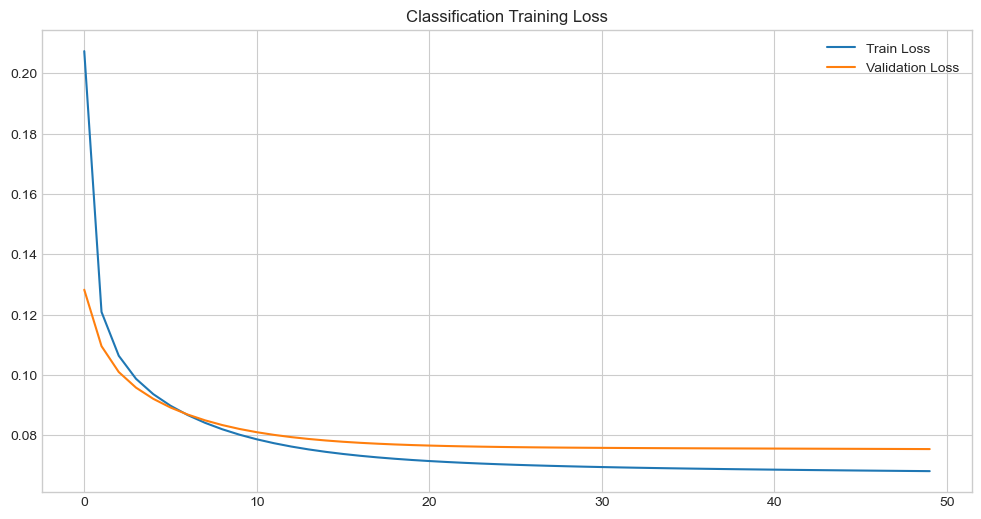

In [ ]:
# 1. Build Model manually to access layers
model_cls = Sequential()
rbf_layer = RoughRBFLayer(input_dim=INPUT_DIM, num_kernels=NUM_CENTERS)
dense_layer = RoughDenseLayer(input_dim=NUM_CENTERS, output_dim=1)

model_cls.add(rbf_layer)
model_cls.add(dense_layer)

# 2. Inject Learned Centers
# This sets c_L = centers and c_U = centers + margin
rbf_layer.init_centers(found_centers)

# 3. Compile with Frozen RBF parameters
# Setting lr_centers=0 and lr_sigmas=0 ensures Part B requirements:
# "Fixed standard deviation and fixed centers, only output weights are Rough trained"
optimizer = SGD(lr=0.001, lr_centers=0.0, lr_sigmas=0.0)
loss_fn = MSELoss() 

model_cls.compile(loss=loss_fn, optimizer=optimizer)

# 4. Train (Supervised Phase)
# Shuffling is important for classification
X_train_c, X_test_c, y_train_c, y_test_c = DataHandler.train_test_split(X_cls, y_cls, train_ratio=0.8, shuffle=True)

print("Training Classification Network (Output Weights Only)...")
history_c = model_cls.fit(X_train_c, y_train_c, 
                          validation_data=(X_test_c, y_test_c),
                          epochs=50, verbose=True)

# Plot Loss
plt.figure()
plt.plot(history_c['loss'], label='Train Loss')
plt.plot(history_c['val_loss'], label='Validation Loss')
plt.title("Classification Training Loss")
plt.legend()
plt.show()

# 9

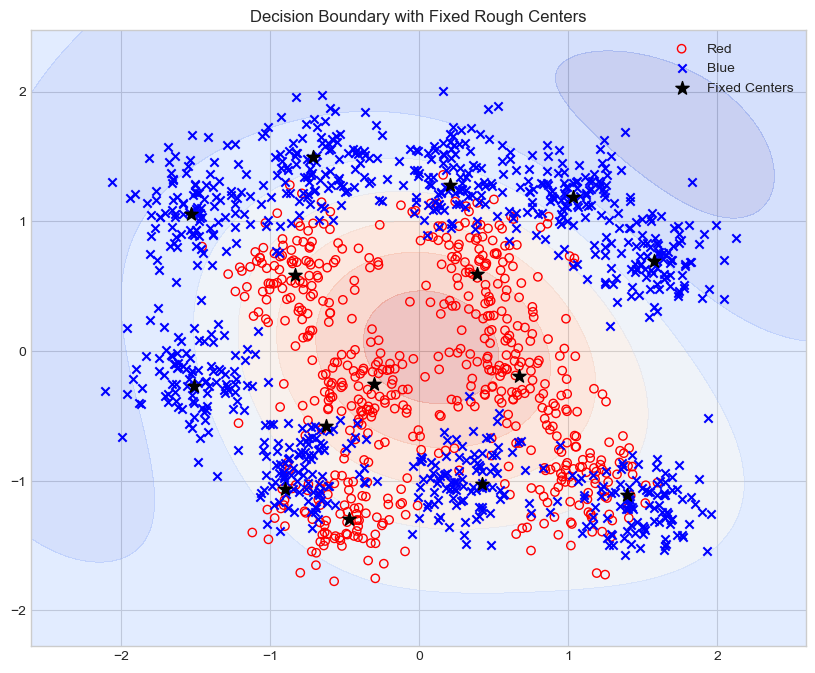

In [ ]:
# 1. Create Meshgrid
x_min, x_max = X_cls[:, 0].min() - 0.5, X_cls[:, 0].max() + 0.5
y_min, y_max = X_cls[:, 1].min() - 0.5, X_cls[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# 2. Predict on Grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
preds = model_cls.predict(grid_points)
preds = preds.reshape(xx.shape)

# 3. Plot Contour
plt.figure(figsize=(10, 8))
# Plot decision regions (output > 0.5 is Blue, < 0.5 is Red)
plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.coolwarm.reversed())

# Plot Original Data
plt.scatter(X_cls[y_cls.flatten()==0, 0], X_cls[y_cls.flatten()==0, 1], edgecolors='r', facecolors='none', label='Red')
plt.scatter(X_cls[y_cls.flatten()==1, 0], X_cls[y_cls.flatten()==1, 1], marker='x', c='b', label='Blue')

# Plot Fixed Centers
plt.scatter(found_centers[:, 0], found_centers[:, 1], c='k', s=100, marker='*', label='Fixed Centers')

plt.title("Decision Boundary with Fixed Rough Centers")
plt.legend()
plt.show()